autism image classification with witha  weighted loss for the cars score: people with severe autism will be treated more importantly in our model

In [1]:
import cv2
import os
import math
import json
import gc

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold
from PIL import Image
import numpy as np

from sklearn.decomposition import PCA
from tensorflow.keras.regularizers import l2

from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.metrics import precision_score, recall_score,  f1_score
from sklearn.model_selection import cross_val_predict

from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import EfficientNetV2B0
from sklearn.preprocessing import StandardScaler


In [2]:
metadata_path = "../dataset/Metadata/data.json"
image_dir = "../dataset/Images/"
input_shape=(224,224)
batch_size=16

In [3]:
def open_image(image_path):
        # Load the image using Pillow
    pil_img = Image.open(image_path).convert("RGB")  # Convert to RGB (if not already)
    img_array = np.array(pil_img)
    return img_array

def show_image(img_array):
    if(img_array.shape[2]== 1):
        plt.imshow(img_array, cmap='gray')
    else:
        plt.imshow(img_array)
    plt.axis('off')
    plt.show()

In [4]:
def get_data_labels_and_metadata(dataset):
    """
    Extracts data and labels from a TensorFlow dataset.

    Args:
        dataset (tf.data.Dataset): The dataset to extract data and labels from.

    Returns:
        Tuple of (data, labels), where:
        - data is a NumPy array of features.
        - labels is a NumPy array of labels.
    """
    data = []
    labels = []
    metadatas=[]
    dataset = dataset.unbatch()

    for features, label, metadata in dataset:
        data.append(features.numpy())
        labels.append(label.numpy())
        metadatas.append(metadata.numpy())

    # Convert lists to NumPy arrays
    data = np.array(data)
    labels = np.array(labels)
    metadata = np.array(metadatas)

    return data, labels, metadata


In [5]:
def create_dataset(data, labels, metadata, batch_size=batch_size, shuffle=True):
    """
    Create a tf.data.Dataset from images and labels.

    Args:
        data (list or np.array): List or array of image data.
        labels (list or np.array): Corresponding labels.
        batch_size (int): Batch size for the dataset.
        shuffle (bool): Whether to shuffle the dataset.

    Returns:
        tf.data.Dataset: A TensorFlow dataset.
    """

    dataset = tf.data.Dataset.from_tensor_slices((data, labels, metadata))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(data))
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [6]:
# One hot encoding
class_mapping = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(["TC", "TS"]),
        values=tf.constant([0, 1])  # Map to integers
    ),
    default_value=-1  # Handle unknown values
)

def one_hot_encode(data, label, metadata):
    num_classes = 2  # Adjust this to the actual number of classes
    # Map string labels to integers

    label = class_mapping.lookup(label)
    # Check for unmapped (invalid) labels
    tf.debugging.assert_greater_equal(label, 0, message="Unknown label encountered")

    label = tf.squeeze(label)
    label = tf.one_hot(label, depth=num_classes)

    return data, label, metadata

In [7]:
def load_metadata_json(metadata_path):
    """
    Load metadata from a JSON file.
    Args:
        metadata_path (str): Path to the metadata file (JSON format).
    Returns:
        list: A list of dictionaries with metadata.
    """
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    return metadata


def match_metadata_with_images_json(image_dir, metadata, target_size=(100, 100)):
    """
    Match images with their metadata and preprocess the data.
    Args:
        image_dir (str): Path to the directory containing images.
        metadata (dict): Metadata grouped by 'TCImages' and 'TSImages'.
        target_size (tuple): Target size for image resizing.
    Returns:
        np.array, np.array, np.array: Preprocessed images, labels, and metadata features.
    """
    data = []
    labels = []
    metadata_features = []

    # Merge metadata entries from both TCImages and TSImages
    metadata_merged = metadata['TCImages'] + metadata['TSImages']

    for entry in metadata_merged:
        # Extract filename, label, and metadata features
        filename = entry['File']
        # participant_id = entry['ParticipantID']
        # age = float(entry['Age']) if 'Age' in entry and entry['Age'] else np.nan
        # gender = entry['Gender'] if 'Gender' in entry else None
        cars_score = entry['CARS']

        # if(image_dir.find("Unseen")):
        #     if(math.isnan(cars_score)):
        #         label= 

        # # Determine the label
        # if(cars_score==0):
        #     label = "TC"
        # else: 
        #     label = "TS"

        subdir=''
        # Determine the image path
        if "TC" in filename:
            subdir = 'TCImages'
            label='TC'
        elif "TS" in filename:
            subdir = 'TSImages'
            label='TS'
            
        image_path = os.path.join(image_dir, subdir, filename)

        # Preprocess the image if it exists

        if os.path.exists(image_path):

            img_array = open_image(image_path)
            data.append(img_array)

            # Collect label and metadata features
            labels.append(label)
            metadata_features.append(
                #'CARS':
                cars_score
                # 'ParticipantID': participant_id,
                # 'Age': age,
                # 'Gender': gender,
            )
        else:
            print(f"Warning: Image {filename} not found! {image_path}")

    labels = np.array(labels)

    # Convert metadata features to structured NumPy array
    # Encode categorical features (e.g., Gender)
    # metadata_features_array = np.array([

    #         feature['CARS']
    #         # float(feature['ParticipantID']),
    #         # feature['Age'],
    #         # hash(feature['Gender']) if feature['Gender'] is not None else 0

    #     #for feature in metadata_features
    # ]).astype('float32')

    metadata_features_array = np.array(metadata_features)

    metadata_features_array = np.nan_to_num(metadata_features_array, nan=0.0)

    return data, labels, metadata_features_array


In [8]:
def average_laplacian(image):
    """Applies an average filter followed by a Laplacian filter."""
    kernel_size = (3, 3)  # Define kernel size for averaging
    average_filtered = cv2.blur(image, kernel_size)

    # Convert image to float64 for Laplacian
    image = image.astype(np.float64)  # Use np.float64 for the Laplacian filter

    # Apply the Laplacian filter
    laplacian_filtered = cv2.Laplacian(image, cv2.CV_64F)

    # Enhance the image
    enhanced_image = laplacian_filtered - average_filtered

    # Convert back to uint8 (clip to valid range)
    enhanced_image = np.clip(enhanced_image, 0, 255).astype(np.uint8)

    return enhanced_image


In [9]:
def preprocess_image(img_array,color, target_size):
    """
    Preprocess a batch of images:
    - Convert each image in the batch to grayscale.
    - Resize each image to the target size.
    Args:
        img_array (np.array): Input batch of images (batch_size, H, W, C).
        target_size (tuple): Desired target size (width, height).
    Returns:
        np.array: Preprocessed grayscale images of target size (batch_size, H', W').
    """
    if img_array is None or img_array.size == 0:
        raise ValueError("Input image array is empty or None.")

    # Ensure the input image has the correct shape
    if img_array.ndim == 3 and img_array.shape[-1] == 1:
        img_array = img_array.squeeze(-1)  # Remove the single channel -> (H, W)

    laplacian_img = average_laplacian(img_array)  # Apply Laplacian filter

    #laplacian_img =cv2.threshold(laplacian_img, 0, 255, cv2.THRESH_BINARY)[1]

    if color is False:
        grayscale_img = cv2.threshold(laplacian_img, 0, 255, cv2.THRESH_BINARY)[1]
        grayscale_img = cv2.cvtColor(laplacian_img, cv2.COLOR_RGB2GRAY)  # Already grayscale
        grayscale_img = cv2.equalizeHist(grayscale_img)  # Histogram equalization
    else:
      grayscale_img = laplacian_img

    # Ensure input to equalizeHist() is single-channel

    # Resize the image
    resized_img = cv2.resize(grayscale_img, target_size, interpolation=cv2.INTER_AREA)

    # Add back the channel dimension for grayscale images
    # if not color:
    #     resized_img = np.expand_dims(resized_img, axis=-1)  # (H, W, 1)

    return resized_img

def preprocess_dataset(concat_data, concat_labels, target_size, color):
    """
    Processes a MapDataset and prepares the dataset.
    Assumes the dataset yields tuples of (image, label).
    """
    data = []
    labels = []

    for img_array, label in zip(concat_data, concat_labels):
        processed_image = preprocess_image(img_array, color, target_size)
        data.append(processed_image)
        labels.append(label)

    # Convert to NumPy arrays
    labels = np.array(labels)

    # Add a channel dimension for grayscale images (required for CNN input)
    data = np.expand_dims(data, axis=-1)

    #processed_dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    return data, labels


In [10]:
def save_dataset(dataset, dataset_name):
    # Initialize lists to store dataset elements (features, labels)
    features_list = []
    labels_list = []
    metadata_list = []

    # Iterate through the dataset and collect the elements
    for features, labels, metadata in dataset:
        features_list.append(features.numpy())  # Convert tensors to NumPy
        labels_list.append(labels.numpy())
        metadata_list.append(metadata.numpy())

    # Save as .npy files
    np.save(f"{dataset_name}_features.npy", np.array(features_list))
    np.save(f"{dataset_name}_labels.npy", np.array(labels_list))
    np.save(f"{dataset_name}_metadata.npy", np.array(metadata_list))
    print(f"Dataset saved as {dataset_name}_features.npy and {dataset_name}_labels.npy")

def load_dataset(dataset_name):
    # Load the saved NumPy arrays
    features = np.load(f"{dataset_name}_features.npy",allow_pickle=True)
    labels = np.load(f"{dataset_name}_labels.npy",allow_pickle=True)
    metadata = np.load(f"{dataset_name}_metadata.npy",allow_pickle=True)

    # Convert them back to TensorFlow tensors
    features_tensor = tf.convert_to_tensor(features)
    labels_tensor = tf.convert_to_tensor(labels)
    metadata_tensor = tf.convert_to_tensor(metadata)

    # Create a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((features_tensor, labels_tensor, metadata_tensor))
    return dataset

In [11]:
# Load the metadata
metadata_list = load_metadata_json(metadata_path)

# Preprocess data and metadata
data, labels, metadata_features = match_metadata_with_images_json(image_dir, metadata_list)

In [12]:
metadata_features

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0

In [13]:
metadata_features.mean()

12.126142595978061

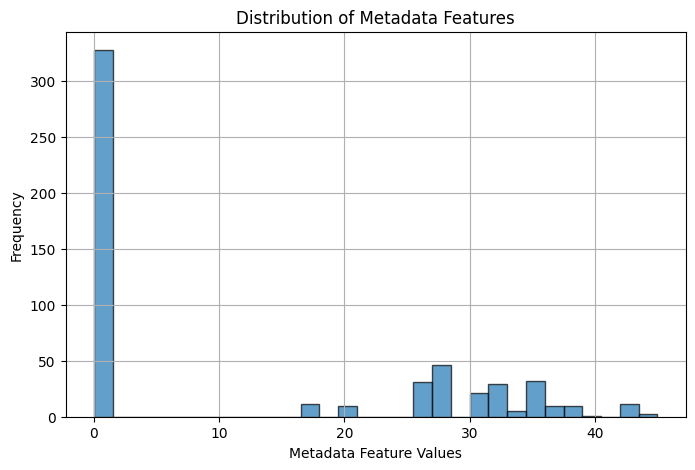

In [14]:
plt.figure(figsize=(8, 5))
plt.hist(metadata_features, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Metadata Feature Values")
plt.ylabel("Frequency")
plt.title("Distribution of Metadata Features")
plt.grid(True)
plt.show()

In [15]:
metadata_features

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0

In [16]:
data, labels = preprocess_dataset(data, labels, target_size=input_shape, color=True)

In [17]:
# Define Data Augmentation Pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
])

def augment_multiple_times(data, labels, metadata_features, augmentations=5, batch_size=32):
    """
    Augment images multiple times while keeping metadata aligned.

    Args:
        data (tf.Tensor): Input tensor of images.
        labels (tf.Tensor): Corresponding labels.
        metadata_features (np.array or tf.Tensor): Metadata for each image.
        augmentations (int): Number of augmentations to apply.
        batch_size (int): Number of images to process per batch.

    Returns:
        augmented_images (tf.Tensor): Augmented images.
        augmented_labels (tf.Tensor): Augmented labels.
        augmented_metadata (tf.Tensor): Augmented metadata.
    """
    augmented_images = []
    augmented_labels = []
    augmented_metadata = []

    for i in range(0, data.shape[0], batch_size):

        # Get current batch
        batch_data = data[i:i+batch_size]
        batch_data = tf.squeeze(batch_data, axis=-1)  # Remove the last channel
        batch_labels = labels[i:i+batch_size]
        batch_metadata = metadata_features[i:i+batch_size]

        # Augment the current batch
        for _ in range(augmentations):
            augmented_images.append(data_augmentation(batch_data))
            augmented_labels.append(batch_labels)
            augmented_metadata.append(batch_metadata)  # Duplicate metadata for each augmentation

    # Convert to tensors
    augmented_images = tf.concat(augmented_images, axis=0)
    augmented_labels = tf.concat(augmented_labels, axis=0)
    augmented_metadata = tf.concat(augmented_metadata, axis=0)

    return augmented_images, augmented_labels, augmented_metadata


In [18]:
with tf.device('/CPU:0'):
    augmented_data, augmented_labels, augmented_metadata = augment_multiple_times(data, labels, metadata_features, augmentations=5, batch_size=batch_size)

In [19]:
data  = tf.squeeze(data, axis=-1)

In [20]:
# Instead of combining original and augmented images:
combined_data = augmented_data
combined_labels = augmented_labels
combined_metadata = augmented_metadata

In [21]:
# combined_data = np.concatenate((data, augmented_data), axis=0)
# combined_labels = np.concatenate((labels, augmented_labels), axis=0)
# combined_metadata = np.concatenate((metadata_features, augmented_metadata), axis=0)

In [22]:
with tf.device('/CPU:0'):
    pre_pca_combined = create_dataset(combined_data, combined_labels, combined_metadata)

In [23]:
# with tf.device('/CPU:0'):
#     save_dataset(pre_pca_combined, "autism2_dataset")

In [24]:
#pre_pca_combined= load_dataset("autism2_dataset")

In [25]:
with tf.device('/CPU:0'):
    train_dataset, test_dataset = tf.keras.utils.split_dataset(
        pre_pca_combined,
        left_size=0.8,
        shuffle=True,
        seed=42,
        #stratify=y_labels
    )

    train_dataset, val_dataset = tf.keras.utils.split_dataset(
        train_dataset,
        left_size=0.8,
        shuffle=True,
        seed=42
    )

In [26]:
train_dataset = train_dataset.map(one_hot_encode)

val_dataset= val_dataset.map(one_hot_encode)

test_dataset= test_dataset.map(one_hot_encode)

In [27]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Loss
#from tf.keras.losses import CategoricalFocalCrossentropy

def focal_loss_with_cars(y_true, y_pred, cars_scores, alpha=0.25, gamma=2.0):
    focal_loss = tfa.losses.SigmoidFocalCrossEntropy(alpha=alpha, gamma=gamma)(y_true, y_pred)

    # Normalize CARS scores to range [1, 2] instead of [1, 28]
    max_cars_score = 45.0
    cars_scores = tf.cast(cars_scores, dtype=tf.float32) / max_cars_score  # Normalize to [0, 1]
    sample_weights = 1.0 + cars_scores  # Rescale to [1, 2]

    weighted_loss = focal_loss * tf.expand_dims(sample_weights, axis=-1)
    
    return tf.reduce_mean(weighted_loss)  # Reduce mean instead of sum

class FocalLoss(Loss):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        # Identify missing values (NaN)
        mask = tf.math.is_nan(y_true)
        
        # Convert CARS Score to binary classification labels (1 for TS, 0 for TC)
        y_true = tf.where(mask, 0.0, tf.cast(y_true > 0, tf.float32))  # Assign 0 to ignored values
        
        # Prevent log(0) issues
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

        # Compute Binary Cross-Entropy
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

        # Compute Focal Loss
        p_t = y_true * y_pred + (1.0 - y_true) * (1.0 - y_pred)
        focal_weight = self.alpha * tf.pow(1.0 - p_t, self.gamma)
        loss = focal_weight * bce

        # Ignore test values (NaN scores) in loss calculation
        loss = tf.where(mask, 0.0, loss)

        return tf.reduce_sum(loss) / tf.reduce_sum(tf.cast(~mask, tf.float32))  # Normalize by valid values

import tensorflow as tf
from tensorflow.keras import backend as K

def custom_focal_loss(alpha=0.25, gamma=2.0):
    """
    Corrected Focal Loss function that supports sample weighting.

    - alpha: Weighting factor for class imbalance.
    - gamma: Focusing parameter for difficult examples.
    """
    def loss_fn(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

        # Compute p_t (probability for the true class)
        pt = tf.where(y_true == 1, y_pred, 1 - y_pred)

        # Compute the focal loss scaling factor
        focal_factor = (1 - pt) ** gamma

        # Compute focal loss per sample
        loss = -alpha * focal_factor * K.log(pt)

        # Ensure we return per-sample losses (Keras will handle sample_weight automatically)
        return tf.reduce_sum(loss, axis=-1)  # Ensure it returns a tensor

    return loss_fn

import tensorflow as tf
from tensorflow.keras import backend as K

def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification.
    Formula:
        loss = -alpha*((1-p)^gamma)*log(p)
    Parameters:
        alpha -- Weighting factor for class imbalance.
        gamma -- Focusing parameter for modulating factor (1-p).
    """
    def focal_loss(y_true, y_pred, sample_weight=None):  # Add sample_weight as an argument
        # Define epsilon to avoid NaN in backpropagation
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

        # Calculate the cross entropy (log loss)
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate weight, which combines alpha and the focusing factor (1-p)^gamma
        weight = alpha * y_true * K.pow((1 - y_pred), gamma)

        # Compute focal loss
        loss = weight * cross_entropy

        # Sum the losses in the batch
        loss = K.sum(loss, axis=1)

        # If sample_weight is provided, multiply it by the loss
        if sample_weight is not None:
            loss = loss * sample_weight  # Apply sample weights

        return loss
    
    return focal_loss


def create_efficient_model():
    # Load EfficientNet model pretrained on ImageNet
    efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    efficientnet_base.trainable = False  # Freeze EfficientNet layers

    # Input for image data
    image_input = Input(shape=(224, 224, 3), name='image_input')

    # Feature extraction
    x = efficientnet_base(image_input)
    x = GlobalAveragePooling2D()(x)  # Convert to feature vector

    # Fully connected layers
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)

    # Output layer (Binary classification)
    output = Dense(2, activation='softmax')(x)

    # Create model
    model = Model(inputs=image_input, outputs=output)

    # Compile model (we pass focal loss dynamically during training)
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  #loss='categorical_crossentropy',
                  #loss = SigmoidFocalCrossEntropy()
                  #loss = tf.keras.losses.CategoricalFocalCrossentropy(),
                  #loss=FocalLoss(),
                  #loss=lambda y_true, y_pred: custom_focal_loss(alpha=0.25, gamma=2.0),
                  #loss='categorical_focal_crossentropy',
                  #loss='binary_focal_crossentropy',
                  loss=categorical_focal_loss(),
                    metrics=['accuracy'])

    return model

# Example usage during training
model = create_efficient_model()

train_accuracy = tf.keras.metrics.CategoricalAccuracy()

@tf.function
def train_step(images, labels, cars_scores):
    """ Custom training step that applies focal loss with CARS-based weighting. """
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = focal_loss_with_cars(labels, predictions, cars_scores)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Update accuracy metric
    train_accuracy.update_state(labels, predictions)

    return loss



c:\Users\Alex\miniconda3\envs\asdlicenta\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Alex\miniconda3\envs\asdlicenta\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an is

In [107]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Concatenate)
from tensorflow.keras.regularizers import l2

def feature_extractor_cnn(input_shapes):
    image_input_shape, metadata_input_shape = input_shapes
    
    # Image input branch
    image_input = Input(shape=image_input_shape)
    x = Conv2D(filters=16, kernel_size=(5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.01))(image_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
    x = Dropout(rate=0.3)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    
    # Metadata input branch
    metadata_input = Input(shape=metadata_input_shape)
    
    # Concatenate image and metadata features
    merged = Concatenate()([x, metadata_input])
    
    model = Model(inputs=[image_input, metadata_input], outputs=merged)
    
    return model


In [108]:
# Example usage: Assuming input images are grayscale 100x100
input_shape = ((224, 224, 3),(1,))
cnn_feature_extractor = feature_extractor_cnn(input_shape)

In [111]:
def create_model_cnn(feature_extractor):
    # Get inputs from feature_extractor
    image_input, metadata_input = feature_extractor.input
    feature_output = feature_extractor.output

    # Fully connected layers
    x = Dense(64, activation='relu')(feature_output)
    x = Dense(2, activation='softmax')(x)

    # Define the final model with both inputs
    model = Model(inputs=[image_input, metadata_input], outputs=x)
    
    model.compile(optimizer=Adam(learning_rate=0.00001),
                  loss='categorical_crossentropy',  
                  metrics=['accuracy'])
    
    return model


In [121]:
model_cnn = create_model_cnn(cnn_feature_extractor)

# 3. Compile the model
model_cnn.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 224, 224, 16  1216        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 112, 112, 16  0          ['conv2d_4[0][0]']               
                                )                                                           

In [125]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history_cnn = model_cnn.fit([train_data, train_metadata], train_labels, batch_size=batch_size, epochs=20, validation_data=([validation_data, validation_metadata], validation_labels),callbacks=[early_stopping])

Epoch 1/20
107/107 [==============================] - 59s 541ms/step - loss: 1.3727 - accuracy: 0.6793 - val_loss: 1.3445 - val_accuracy: 0.7292
Epoch 2/20
107/107 [==============================] - 16s 145ms/step - loss: 1.2618 - accuracy: 0.7669 - val_loss: 1.2970 - val_accuracy: 0.7546
Epoch 3/20
107/107 [==============================] - 16s 146ms/step - loss: 1.1959 - accuracy: 0.7979 - val_loss: 1.2728 - val_accuracy: 0.7755
Epoch 4/20
107/107 [==============================] - 16s 148ms/step - loss: 1.1609 - accuracy: 0.8148 - val_loss: 1.2523 - val_accuracy: 0.7685
Epoch 5/20
107/107 [==============================] - 15s 144ms/step - loss: 1.1117 - accuracy: 0.8446 - val_loss: 1.2646 - val_accuracy: 0.7593
Epoch 6/20
107/107 [==============================] - 16s 146ms/step - loss: 1.0692 - accuracy: 0.8616 - val_loss: 1.2404 - val_accuracy: 0.7477
Epoch 7/20
107/107 [==============================] - 15s 145ms/step - loss: 1.0404 - accuracy: 0.8797 - val_loss: 1.2332 - val_ac

In [129]:
# Assuming you have test data: X_test_image (test images) and X_test_cars (CARS scores for test)
# And the true labels for test data: y_test
with tf.device('/CPU:0'):
    #test_loss, test_accuracy = model.evaluate([test_data, test_metadata], test_labels)
    y_pred = model_cnn.predict([unseen_data, unseen_metadata])



1/1 [==============================] - 1s 911ms/step


In [132]:
y_pred = np.argmax(y_pred,axis=1)

In [133]:
accuracy_score(y_pred, unseen_labels_1)

0.9

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

In [34]:
train_data, train_labels, train_metadata = get_data_labels_and_metadata(train_dataset)

In [30]:
validation_data, validation_labels, validation_metadata = get_data_labels_and_metadata(val_dataset)

In [28]:
#train_labels = np.argmax(train_labels, axis=1)

scaler = StandardScaler()
train_metadata = scaler.fit_transform(train_metadata.reshape(-1, 1)).flatten()

In [29]:
#validation_labels = np.argmax(validation_labels, axis=1)

validation_metadata = scaler.transform(validation_metadata.reshape(-1, 1)).flatten()

In [31]:
model = create_efficient_model()

In [89]:
def reset_weights(model):
    for layer in model.layers:
        if hasattr(layer, 'kernel_initializer') and hasattr(layer, 'bias_initializer'):
            layer.kernel.assign(layer.kernel_initializer(tf.shape(layer.kernel)))
            layer.bias.assign(layer.bias_initializer(tf.shape(layer.bias)))

In [96]:
reset_weights(model)

c:\Users\Alex\miniconda3\envs\asdlicenta\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [67]:
num_epochs = 10  # Set number of epochs

for epoch in range(num_epochs):
    epoch_loss = 0
    train_accuracy.reset_states()  # Reset accuracy at the start of each epoch

    for batch_images, batch_labels, batch_cars_scores in train_dataset:
        loss = train_step(batch_images, batch_labels, batch_cars_scores)
        epoch_loss += loss.numpy()
    
    # Print loss and accuracy for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy.result().numpy():.4f}")


Epoch 1/10, Loss: 6161.0048, Accuracy: 0.5671
Epoch 2/10, Loss: 5375.2080, Accuracy: 0.7139
Epoch 3/10, Loss: 5021.6027, Accuracy: 0.7454
Epoch 4/10, Loss: 4892.0218, Accuracy: 0.7431
Epoch 5/10, Loss: 4765.2960, Accuracy: 0.7483
Epoch 6/10, Loss: 4712.4300, Accuracy: 0.7477
Epoch 7/10, Loss: 4643.0626, Accuracy: 0.7494


KeyboardInterrupt: 

In [ ]:
#train_labels = np.argmax(train_labels, axis=1)

train_metadata = np.reshape(train_metadata, (1744,))


AxisError: axis 1 is out of bounds for array of dimension 1

In [35]:
max_cars_score = 60
train_metadata = tf.cast(train_metadata, dtype=tf.float32) / max_cars_score  # Normalize to [0, 1]

train_metadata = tf.constant(1, dtype=float) + train_metadata
# for i in range(len(train_metadata)):
#     train_metadata[i] = 1.0 + train_metadata[i]  # Rescale to [1, 2]

In [36]:
for i in range(len(train_metadata)):
    print(train_metadata[i])

tf.Tensor(1.5166667, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.5416667, shape=(), dtype=float32)
tf.Tensor(1.5166667, shape=(), dtype=float32)
tf.Tensor(1.45, shape=(), dtype=float32)
tf.Tensor(1.6416667, shape=(), dtype=float32)
tf.Tensor(1.3333334, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.5583334, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.5083333, shape=(), dtype=float32)
tf.Tensor(1.45, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.425, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.45, shape=(), dtype=float32)
tf.Tensor(1.5416667, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.3333334, shape=

In [37]:
with tf.device('/CPU:0'):
    history = model.fit(
        train_data,  # Inputs: image data and CARS scores
        train_labels,           # Labels (0 for TC, 1 for TS)
        epochs=15,
        sample_weight=train_metadata,
        validation_data=(validation_data, validation_labels),
        callbacks=[early_stopping, reduce_lr],
        batch_size=32
    )

Epoch 1/15
55/55 [==============================] - 119s 2s/step - loss: 0.0427 - accuracy: 0.7294 - val_loss: 0.0351 - val_accuracy: 0.6968 - lr: 0.0010
Epoch 2/15
55/55 [==============================] - 115s 2s/step - loss: 0.0397 - accuracy: 0.7317 - val_loss: 0.0325 - val_accuracy: 0.7431 - lr: 0.0010
Epoch 3/15
55/55 [==============================] - 99s 2s/step - loss: 0.0387 - accuracy: 0.7638 - val_loss: 0.0320 - val_accuracy: 0.7477 - lr: 0.0010
Epoch 4/15
55/55 [==============================] - 111s 2s/step - loss: 0.0364 - accuracy: 0.7792 - val_loss: 0.0308 - val_accuracy: 0.7616 - lr: 0.0010
Epoch 5/15
55/55 [==============================] - 133s 2s/step - loss: 0.0362 - accuracy: 0.7592 - val_loss: 0.0300 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/15
55/55 [==============================] - 122s 2s/step - loss: 0.0348 - accuracy: 0.7787 - val_loss: 0.0289 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 7/15
55/55 [==============================] - 125s 2s/step - loss: 0.03

In [45]:
model.save_weights("./weights/autism2")

In [53]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects

# Register your loss function as a custom object
get_custom_objects().update({"categorical_focal_loss": categorical_focal_loss()})

# Save the model
model.save("efficient_80", save_format="h5")

# Load the model with the custom loss
model = load_model("efficient_80.h5", custom_objects={"categorical_focal_loss": categorical_focal_loss()})


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [46]:
model.save('efficient_80')

INFO:tensorflow:Assets written to: efficient_80\assets


INFO:tensorflow:Assets written to: efficient_80\assets


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [69]:
# Load the metadata
unseen_metadata_list = load_metadata_json("../dataset/Unseen/Metadata/data.json")

# Preprocess data and metadata
unseen_data, unseen_labels, unseen_metadata_features = match_metadata_with_images_json("../dataset/Unseen/Images/", unseen_metadata_list)

In [71]:
unseen_data, unseen_labels = preprocess_dataset(unseen_data, unseen_labels, target_size=input_shape, color=True)

In [45]:
unseen_metadata_features.fill(metadata_features.mean())

In [80]:
unseen_augmented_data, unseen_augmented_labels, unseen_augmented_metadata = augment_multiple_times(unseen_data, unseen_labels, unseen_metadata_features, augmentations=5)

In [49]:
unseen_dataset = create_dataset(unseen_data, unseen_labels, unseen_metadata_features)

In [39]:
metadata_features.mean(), np.array(combined_metadata).mean()

(12.042830540037244, 12.042830540037244)

In [81]:
unseen_metadata_features, unseen_labels, unseen_augmented_labels

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array(['TC', 'TC', 'TC', 'TC', 'TC', 'TC', 'TC', 'TC', 'TC', 'TC', 'TS',
        'TS', 'TS', 'TS', 'TS', 'TS', 'TS', 'TS', 'TS', 'TS'], dtype='<U2'),
 <tf.Tensor: shape=(100,), dtype=string, numpy=
 array([b'TC', b'TC', b'TC', b'TC', b'TC', b'TC', b'TC', b'TC', b'TC',
        b'TC', b'TS', b'TS', b'TS', b'TS', b'TS', b'TS', b'TS', b'TS',
        b'TS', b'TS', b'TC', b'TC', b'TC', b'TC', b'TC', b'TC', b'TC',
        b'TC', b'TC', b'TC', b'TS', b'TS', b'TS', b'TS', b'TS', b'TS',
        b'TS', b'TS', b'TS', b'TS', b'TC', b'TC', b'TC', b'TC', b'TC',
        b'TC', b'TC', b'TC', b'TC', b'TC', b'TS', b'TS', b'TS', b'TS',
        b'TS', b'TS', b'TS', b'TS', b'TS', b'TS', b'TC', b'TC', b'TC',
        b'TC', b'TC', b'TC', b'TC', b'TC', b'TC', b'TC', b'TS', b'TS',
        b'TS', b'TS', b'TS', b'TS', b'TS', b'TS', b'TS', b'TS', b'TC',
        b'TC', b'TC', b'TC', b'TC', b'TC', b'TC', b'TC', b'TC', 

In [50]:
unseen_dataset= unseen_dataset.map(one_hot_encode)

In [51]:
unseen_data, unseen_labels, unseen_metadata_features= get_data_labels_and_metadata(unseen_dataset)

In [42]:
unseen_labels_1 = np.array([0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1])

In [52]:
unseen_labels, unseen_data, unseen_labels_1

(array([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]], dtype=float32),
 array([[[[[0],
           [0],
           [0]],
 
          [[0],
           [0],
           [0]],
 
          [[0],
           [0],
           [0]],
 
          ...,
 
          [[0],
           [0],
           [0]],
 
          [[0],
           [0],
           [0]],
 
          [[0],
           [0],
           [0]]],
 
 
         [[[0],
           [0],
           [0]],
 
          [[0],
           [0],
           [0]],
 
          [[0],
           [0],
           [0]],
 
          ...,
 
          [[0],
           [0],
           [0]],
 
          [[0],
           [0],
           [0]],
 
          [[0],
           [0],
           [0]]],
 
 
         [[[0],
           [0],
           

In [38]:
test_data, test_labels, test_metadata = get_data_labels_and_metadata(test_dataset)

In [39]:
test_metadata.fill(1)

In [ ]:
# test_metadata = tf.cast(test_metadata, dtype=tf.float32) / max_cars_score  # Normalize to [0, 1]
# test_metadata = 1.0 + test_metadata  # Rescale to [1, 2]

In [40]:
test_metadata

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [41]:
y_pred=model.predict(test_data)

17/17 [==============================] - 9s 63ms/step


In [42]:
from sklearn.metrics import accuracy_score

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)  # Picks the highest probability index
y_true_labels = np.argmax(test_labels, axis=1)  # Convert one-hot to labels

# Compute accuracy
acc = accuracy_score(y_true_labels, y_pred_labels)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.8051


In [49]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

recall_score(y_true_labels, y_pred_labels), precision_score(y_true_labels, y_pred_labels) ,f1_score(y_true_labels, y_pred_labels)

(0.7289719626168224, 0.7647058823529411, 0.7464114832535885)

In [43]:
y_pred_labels

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,

In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_labels, y_true_labels)
cm

array([[282,  58],
       [ 48, 156]], dtype=int64)

In [67]:
test_labels = np.argmax(test_labels, axis=1)

test_metadata = scaler.transform(test_metadata.reshape(-1, 1)).flatten()

In [68]:
#unseen_labels = np.argmax(unseen_labels, axis=1)

unseen_metadata = scaler.transform(unseen_metadata_features.reshape(-1, 1)).flatten()

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by StandardScaler.

In [80]:
unseen_data = np.squeeze(unseen_data, axis=-1)  # Remove last dimension if it's 1

In [91]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Ensure labels are strings before mapping
unseen_augmented_labels = np.array(unseen_augmented_labels, dtype=str)  # Convert bytes to strings

# Convert string labels ('TC', 'TS') to integers
label_mapping = {'TC': 0, 'TS': 1}
unseen_labels_int = np.array([label_mapping[label.decode() if isinstance(label, bytes) else label] 
                              for label in unseen_augmented_labels])

# Now apply one-hot encoding
unseen_labels_one_hot = to_categorical(unseen_labels_int, num_classes=2)

print(unseen_labels_one_hot)


[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


4/4 [==============================] - 0s 64ms/step


In [92]:
unseen_data.shape, y_pred.shape, unseen_labels_one_hot.shape, unseen_augmented_labels.shape

((20, 224, 224, 3, 1), (100, 2), (100, 2), (100,))

In [104]:
import numpy as np
from sklearn.metrics import accuracy_score

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)  # Picks the highest probability index
y_true_labels = np.argmax(unseen_labels_one_hot, axis=1)  # Convert one-hot to labels

# Compute accuracy
acc = accuracy_score(y_true_labels, y_pred_labels)
print(f"Accuracy: {acc:.4f}")


Accuracy: 0.9000


In [85]:
accuracy_score(y_pred,unseen_labels_1)

ValueError: Classification metrics can't handle a mix of continuous-multioutput and multilabel-indicator targets

In [83]:
# Assuming you have test data: X_test_image (test images) and X_test_cars (CARS scores for test)
# And the true labels for test data: y_test
with tf.device('/CPU:0'):
    #test_loss, test_accuracy = model.evaluate([test_data, test_metadata], test_labels)
    test_loss, test_accuracy = model.evaluate(unseen_data, unseen_labels_1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1/1 [==============================] - 2s 2s/step - loss: 0.3785 - accuracy: 1.0000
Test Loss: 0.3785061836242676
Test Accuracy: 1.0


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predictions for the test set
with tf.device('/CPU:0'):
    y_pred_prob = model.predict([unseen_data, unseen_metadata])  # Probabilities for each class
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)

# Classification report (Precision, Recall, F1-score)
print("Classification Report:")
print(classification_report(unseen_labels_1, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(unseen_labels_1, y_pred))

# AUC-ROC Score
auc_roc = roc_auc_score(unseen_labels_1, y_pred_prob)
print(f"AUC-ROC: {auc_roc}")


1/1 [==============================] - 2s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

Confusion Matrix:
[[5 0]
 [0 5]]
AUC-ROC: 1.0


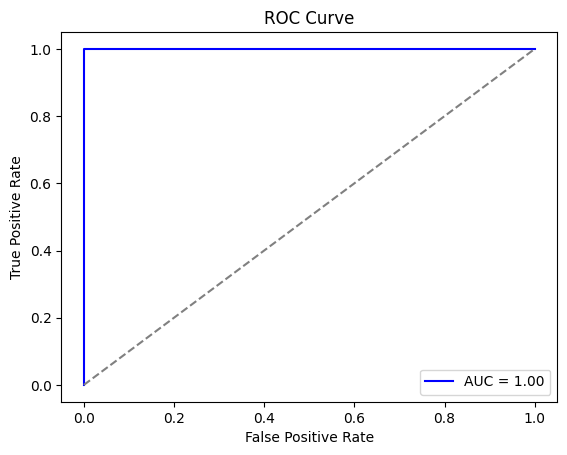

In [76]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(unseen_labels_1, y_pred_prob)
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_roc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
all_data, all_labels, all_metadata = get_data_labels_and_metadata(pre_pca_combined)

In [ ]:
def count_subarray_occurrences(big_array, small_array):
    # Ensure the small_array is a 1D array for simplicity
    small_array = np.asarray(small_array)
    big_array = np.asarray(big_array)

    # Lengths of both arrays
    len_big = len(big_array)
    len_small = len(small_array)

    # Count the number of times the small array appears inside the big array
    count = 0
    for i in range(len_big - len_small + 1):
        if np.array_equal(big_array[i:i+len_small], small_array):
            count += 1

    return count

In [ ]:
unique, counts = np.unique(train_metadata, return_counts=True)

unique, counts

(array([-0.79105526,  0.31794864,  0.51365521,  0.87245059,  0.93768611,
         0.97030387,  1.1986282 ,  1.23124597,  1.26386373,  1.29648149,
         1.32909925,  1.39433478,  1.4595703 ,  1.49218806,  1.59004135,
         1.68789463,  1.72051239,  1.81836568,  1.98145449,  2.14454329]),
 array([1262,   40,   41,   71,   49,  165,   37,   47,   41,   24,   40,
          18,   78,   59,   37,    7,   29,    4,   42,    5]))

In [ ]:
unique, counts = np.unique(test_metadata, return_counts=True)

unique, counts

(array([-0.79105526,  0.31794864,  0.51365521,  0.87245059,  0.93768611,
         0.97030387,  1.1986282 ,  1.23124597,  1.26386373,  1.29648149,
         1.32909925,  1.39433478,  1.4595703 ,  1.49218806,  1.59004135,
         1.68789463,  1.72051239,  1.98145449,  2.14454329]),
 array([393,   9,  12,  14,  21,  61,  15,  12,  17,   6,  14,   7,  18,
         17,  14,   2,   8,  13,   3]))

In [32]:
train_metadata.shape, test_metadata.shape, validation_metadata.shape, all_metadata.shape

NameError: name 'all_metadata' is not defined

In [ ]:
train_data.shape, test_data.shape, validation_data.shape, all_data.shape

((2096, 224, 224, 3),
 (656, 224, 224, 3),
 (528, 224, 224, 3),
 (3280, 224, 224, 3))

In [ ]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Calibrate the model (if needed)
calibrated_model = CalibratedClassifierCV(model, method='sigmoid')
calibrated_model.fit([X_train_image, X_train_cars], y_train)

# Predict calibrated probabilities
calibrated_probs = calibrated_model.predict_proba([X_test_image, X_test_cars])[:, 1]


In [ ]:
accuracy_score(test_labels, y_pred)

In [ ]:
# Assuming train_labels is one-hot encoded
#train_labels_1 = np.concatenate([train_labels, train_metadata.reshape(-1, 1)], axis=1)

In [ ]:
#val_data, val_labels, val_metadata=get_data_labels_and_metadata(val_dataset)

In [ ]:
# Assuming train_labels is one-hot encoded
#val_labels_1 = np.concatenate([val_labels, val_metadata.reshape(-1, 1)], axis=1)

In [ ]:
#train_labels_1

array([[ 1.        ,  0.        , -0.79105526],
       [ 1.        ,  0.        , -0.79105526],
       [ 1.        ,  0.        , -0.79105526],
       ...,
       [ 1.        ,  0.        , -0.79105526],
       [ 0.        ,  1.        ,  1.98145449],
       [ 1.        ,  0.        , -0.79105526]])

In [ ]:
with tf.device('/CPU:0'):
    # Train model with weighted loss
    history_efficient = model_efficient.fit(
        train_data, train_labels_1,
        validation_data=(val_data, val_labels_1),
        batch_size=32,
        epochs=10,
        callbacks=[early_stopping, reduce_lr]
    )


Epoch 1/10
 66/241 [=======>......................] - ETA: 6:00 - loss: 0.3894 - accuracy: 0.2538

KeyboardInterrupt: 

In [77]:
# Check the distribution of severity scores to see if they are highly skewed
print(np.min(train_metadata), np.max(train_metadata))

0.0 1.0


In [80]:
np.mean(train_metadata)

0.27447757

In [ ]:
train_metadata_normalized = (train_metadata - np.min(train_metadata)) / (np.max(train_metadata) - np.min(train_metadata))

In [ ]:
train_metadata_standardized = (train_metadata - np.mean(train_metadata)) / np.std(train_metadata)
train_metadata_standardized

array([-0.78583484, -0.78583484, -0.78583484, ..., -0.78583484,
        1.99537679, -0.78583484])

In [ ]:
y_pred = model_efficient.predict(test_dataset)

test_data, test_labels = get_data_and_labels(test_dataset)

In [ ]:
# y_pred = np.argmax(y_pred, axis=1)
# test_labels = np.argmax(test_labels, axis=1)

accuracy_score(test_labels, y_pred)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split

In [ ]:
import os
import json
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np

class AutismDataset(Dataset):
    def __init__(self, json_file, autism_folder, control_folder, transform=None):
        self.transform = transform

        # Load JSON file
        with open(json_file, 'r') as f:
            data = json.load(f)

        self.data = []
        severity_scores = []

        for item in data['TCImages']:
            file_name = item['File']
            cars_score = item['CARS']

            # Determine class and image folder
            if np.isnan(cars_score):  # Control group
                label = 0
                image_path = os.path.join(control_folder, file_name)
                severity = 0  # No severity for control group
            else:  # Autism group
                label = 1
                image_path = os.path.join(autism_folder, file_name)
                severity = cars_score
                severity_scores.append(cars_score)

            self.data.append({
                "image_path": image_path,
                "label": label,
                "severity": severity
            })

        # Normalize severity scores for autism cases
        if severity_scores:
            max_severity = max(severity_scores)
            for item in self.data:
                if item['label'] == 1:
                    item['severity'] /= max_severity

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]['image_path']
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        severity = torch.tensor(self.data[idx]['severity'], dtype=torch.float32)
        label = torch.tensor(self.data[idx]['label'], dtype=torch.long)

        return image, severity, label


In [ ]:
class ImageSeverityModel(nn.Module):
    def __init__(self, num_classes=2):
        super(ImageSeverityModel, self).__init__()

        # Pretrained CNN Backbone (ResNet50)
        self.cnn = models.efficientnet_b0(pretrained=True)
        self.cnn.fc = nn.Identity()  # Remove last layer
        self.image_fc = nn.Linear(1000, 256)  # Reduce image feature size

        # Linear layer for severity score (1 input feature)
        self.severity_fc = nn.Linear(1, 256)

        # Final classification layer (Image + Severity)
        self.fc = nn.Linear(256 + 256, num_classes)

    def forward(self, image, severity):
        img_features = self.cnn(image)
        img_features = self.image_fc(img_features)

        sev_features = self.severity_fc(severity.unsqueeze(1))  # Expand dimensions

        combined = torch.cat((img_features, sev_features), dim=1)
        output = self.fc(combined)

        return output


In [ ]:
class WeightedLoss(nn.Module):
    def __init__(self):
        super(WeightedLoss, self).__init__()
        self.loss_fn = nn.CrossEntropyLoss(reduction='none')

    def forward(self, logits, labels, severity_scores):
        weights = severity_scores + 1  # Ensure weight is at least 1
        base_loss = self.loss_fn(logits, labels)
        weighted_loss = base_loss * weights
        return weighted_loss.mean()  # Average loss


In [ ]:
# Hyperparameters

metadata_path = "../dataset/Metadata/data.json"
image_dir = "../dataset/Images/"

image_folder_autism = image_dir+ "TSImages/"
#csv_file_autism = "../dataset/Metadata/Metadata_TS.csv"

image_folder_control = image_dir+ "TCImages/"
#csv_file_control = "../dataset/Metadata/Metadata_TC.csv"

num_epochs=10
learning_rate=0.00001

# Transformations for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create Dataset & DataLoader
dataset = AutismDataset(json_file=metadata_path ,
                        autism_folder=image_folder_autism,
                        control_folder= image_folder_control,
                         transform= transform)

# Assuming `dataset` is a DataFrame or list of records with 'ParticipantID' column
# First, get the unique ParticipantIDs
unique_participants = dataset['ParticipantID'].unique()

# Split the unique participants into train, validation, and test
train_participants, temp_participants = train_test_split(unique_participants, test_size=0.3, random_state=42)
val_participants, test_participants = train_test_split(temp_participants, test_size=0.5, random_state=42)

# Now filter your dataset based on ParticipantID
train_data = dataset[dataset['ParticipantID'].isin(train_participants)]
val_data = dataset[dataset['ParticipantID'].isin(val_participants)]
test_data = dataset[dataset['ParticipantID'].isin(test_participants)]

# Create DataLoader objects
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


# Model initialization
model = ImageSeverityModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop with Accuracy Logging
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, severity_scores, labels in train_loader:
        images, severity_scores, labels = images.to(device), severity_scores.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, severity_scores)

        # Calculate the loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate train accuracy in percentage
    train_accuracy = 100 * correct_train / total_train

    # Validation phase
    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, severity_scores, labels in val_loader:
            images, severity_scores, labels = images.to(device), severity_scores.to(device), labels.to(device)

            outputs = model(images, severity_scores)
            _, predicted = torch.max(outputs, 1)

            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate validation accuracy in percentage
    val_accuracy = 100 * correct_val / total_val

    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

# Final test evaluation after training
model.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for images, severity_scores, labels in test_loader:
        images, severity_scores, labels = images.to(device), severity_scores.to(device), labels.to(device)

        outputs = model(images, severity_scores)
        _, predicted = torch.max(outputs, 1)

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

# Test accuracy in percentage
test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.2f}%")


TypeError: list indices must be integers or slices, not str

In [ ]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, severity_scores, labels in train_loader:
        images, severity_scores, labels = images.to(device), severity_scores.to(device), labels.to(device)
        outputs = model(images, severity_scores)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 100.00%
